In [ ]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive')

# TODO: Enter the foldername in your Drive where you have saved the unzipped
# assignment folder, e.g. 'cse493g1/assignments/assignment5/'
FOLDERNAME = 'cse493g1/assignments/assignment5_colab/assignment5/'
assert FOLDERNAME is not None, "[!] Enter the foldername."

# Now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

# This downloads the COCO dataset to your Drive
# if it doesn't already exist.
%cd /content/drive/My\ Drive/$FOLDERNAME/cse493g1/datasets/
!bash get_datasets.sh
%cd /content/drive/My\ Drive/$FOLDERNAME

Mounted at /content/drive
/content/drive/My Drive/cse493g1/assignments/assignment5_colab/assignment5/cse493g1/datasets
/content/drive/My Drive/cse493g1/assignments/assignment5_colab/assignment5


<p align="center">
    <small>
  <strong style="font-size:2.5em; line-height:1.3;">
    “AI is made by humans, intended to behave by humans, and, ultimately, to impact humans’ lives and human society.”
  </strong>
</p>
<p align="right">
  — <em>Fei-Fei Li</em>
</p>

# Reinforcement Learning from Human Feedback (RLHF)

AI, by design, embodies our intentions and must act in ways that reflect human values, safety, and societal needs. Long before today’s algorithms, humanity devised rules and frameworks to keep powerful tools aligned with our goals. The very first alignment “law” appears in Isaac Asimov’s **Three Laws of Robotics**, a fictional yet enduring blueprint that insists any robot must never harm a human, must obey human orders, and must protect its own existence only so long as it does not conflict with the first two laws. Decades later.  For LLMs—the engines of today’s AI revolution—RLHF represents the capstone of this lineage. By collecting human preference data, training a learned reward model, and then fine-tuning with policy gradients, RLHF embeds human judgments directly into the training loop. In doing so, it aligns the model’s vast, unprecedented capabilities with our collective will, ethics, and societal needs.

## What is RLHF?

Reinforcement Learning from Human Feedback (RLHF) is a machine learning approach that uses human feedback to train AI models. Instead of relying solely on predefined objective functions, RLHF incorporates human preferences or judgments to guide the learning process.

In the context of language models, RLHF has become particularly important for aligning the model's outputs with human values, preferences, and intentions - a process known as **alignment**. Traditional language models trained on large text corpora might generate fluent and coherent text, but they often lack awareness of human preferences, ethical considerations, and safety constraints.

## RLHF Techniques

In this assignment, we'll explore three major techniques for RLHF-based alignment:

1. **REINFORCE Algorithm** - A classic policy gradient method adapted for language models
2. **REINFORCE with KL Regularization** - Adding a constraint to prevent the model from deviating too far from its original behavior
3. **Direct Preference Optimization (DPO)** - A more recent approach that directly optimizes for human preferences without an explicit reward model. Been  widely used in popular models like GPT, Gemini, LLaMA, etc.

You will work with a BLIP vision-language model to generate image captions and optimize them for formality using a DeBERTa-based formality classifier as the reward model.

In [ ]:
# Install required packages
!pip install transformers==4.46.3 torch torchvision pillow matplotlib tqdm numpy

In [41]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import json
import os
import random
from tqdm.auto import tqdm

# Import your RLHF implementation
from cse493g1.rlhf.image_captioning_rlhf import ImageCaptioningRLHF

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using device: {device}')

# Set random seeds for reproducibility
random.seed(42)
torch.manual_seed(42)
np.random.seed(42)

Using device: cuda


# Section 1: Setup and Data Creation

First, let's create some sample data for training and testing. In a real scenario, you would use actual images from datasets like COCO or Flickr.

Created 16 training images and 8 test images


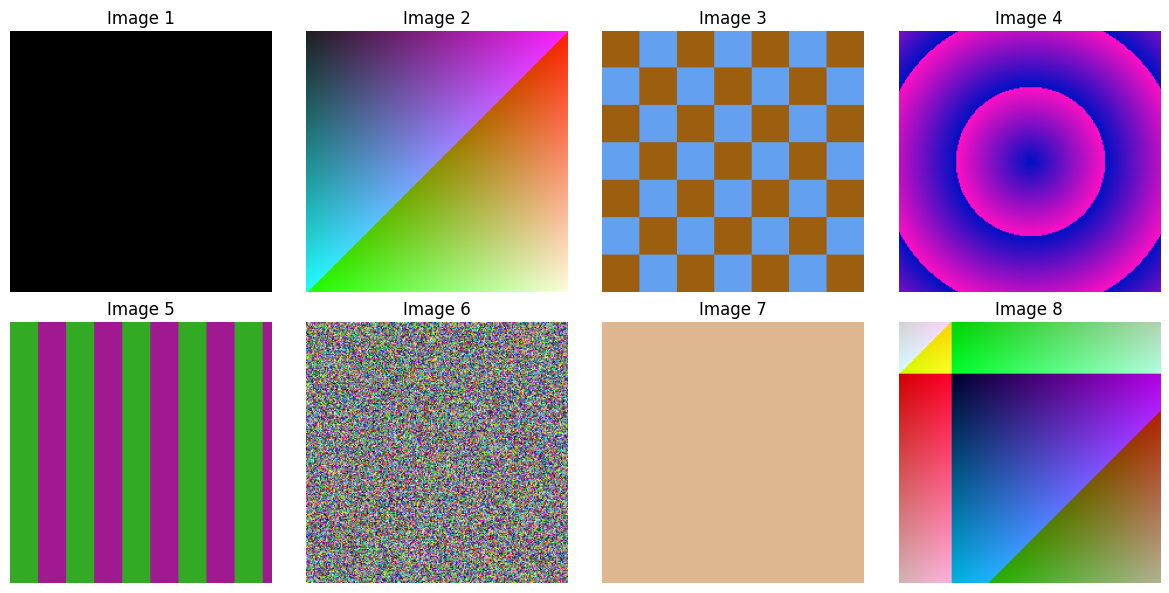

In [34]:
def create_sample_images(num_images=20):
    """Create sample synthetic images for demonstration."""
    images = []

    for i in range(num_images):
        # Create images with different patterns - make each unique
        pattern_type = i % 6  # Increased variety with 6 different patterns

        if pattern_type == 0:
            # Solid color images with unique colors
            color = ((i * 37) % 255, (i * 73) % 255, (i * 109) % 255)
            img = Image.new('RGB', (224, 224), color=color)

        elif pattern_type == 1:
            # Gradient images with different directions
            img = Image.new('RGB', (224, 224))
            pixels = img.load()
            offset = i * 30  # Different offset for each gradient
            for x in range(224):
                for y in range(224):
                    pixels[x, y] = ((x + offset) % 255, (y + offset) % 255, (x + y + offset) % 255)

        elif pattern_type == 2:
            # Checkerboard pattern with different sizes
            img = Image.new('RGB', (224, 224))
            pixels = img.load()
            checker_size = 16 + (i * 8) % 48  # Different checker sizes
            color1 = ((i * 50) % 255, (i * 80) % 255, (i * 120) % 255)
            color2 = (255 - color1[0], 255 - color1[1], 255 - color1[2])
            for x in range(224):
                for y in range(224):
                    if (x // checker_size + y // checker_size) % 2:
                        pixels[x, y] = color1
                    else:
                        pixels[x, y] = color2

        elif pattern_type == 3:
            # Circular patterns
            img = Image.new('RGB', (224, 224))
            pixels = img.load()
            center_x, center_y = 112, 112
            base_color = ((i * 60) % 255, (i * 90) % 255, (i * 150) % 255)
            for x in range(224):
                for y in range(224):
                    distance = ((x - center_x) ** 2 + (y - center_y) ** 2) ** 0.5
                    intensity = int((distance * (i + 1)) % 255)
                    pixels[x, y] = (intensity, base_color[1], base_color[2])

        elif pattern_type == 4:
            # Striped patterns
            img = Image.new('RGB', (224, 224))
            pixels = img.load()
            stripe_width = 8 + (i * 4) % 24
            color1 = ((i * 40) % 255, (i * 70) % 255, (i * 100) % 255)
            color2 = ((i * 140) % 255, (i * 170) % 255, (i * 200) % 255)
            for x in range(224):
                for y in range(224):
                    if (x // stripe_width) % 2:
                        pixels[x, y] = color1
                    else:
                        pixels[x, y] = color2

        else:  # pattern_type == 5
            # Controlled random noise (seeded per image)
            # Use a different seed for each image to ensure uniqueness
            local_rng = np.random.RandomState(42 + i)  # Different seed per image
            noise_array = local_rng.randint(0, 255, (224, 224, 3), dtype=np.uint8)
            img = Image.fromarray(noise_array)

        images.append(img)

    return images

# Create sample data
train_images = create_sample_images(16)
test_images = create_sample_images(8)

print(f"Created {len(train_images)} training images and {len(test_images)} test images")

# Display a few sample images
fig, axes = plt.subplots(2, 4, figsize=(12, 6))
for i, ax in enumerate(axes.flat):
    ax.imshow(train_images[i])
    ax.set_title(f'Image {i+1}')
    ax.axis('off')
plt.tight_layout()
plt.show()

# Section 2: Initialize RLHF Trainer

Now let's initialize our RLHF trainer. This will load the BLIP model and the formality reward model.

In [ ]:
# Initialize the RLHF trainer
rlhf_trainer = ImageCaptioningRLHF(device=device)

# Test caption generation
print("Testing caption generation...")
_, sample_captions = rlhf_trainer.generate_captions(train_images[:3], max_new_tokens=15)

for i, caption in enumerate(sample_captions):
    print(f"Image {i+1}: {caption}")

# Test reward computation
print("\nTesting formality rewards...")
rewards = rlhf_trainer.compute_formality_reward(sample_captions)
for i, (caption, reward) in enumerate(zip(sample_captions, rewards)):
    print(f"Caption: '{caption}' -> Reward: {reward:.3f}")

Using device: cuda
Loading Vision-Language Model...
Loading Formality Reward Model...
✓ Models loaded successfully
Testing caption generation...
Image 1: the emerald hill hotel
Image 2: a multi colored background
Image 3: blue squares on a brown checker

Testing formality rewards...
Caption: 'the emerald hill hotel' -> Reward: 0.003
Caption: 'a multi colored background' -> Reward: 0.003
Caption: 'blue squares on a brown checker' -> Reward: 0.003


# Section 3: Implement REINFORCE Loss

**TODO**: Complete the `compute_reinforce_loss` method in `image_captioning_rlhf.py`

The REINFORCE loss should:
1. Get model outputs for the generated sequences
2. Compute log probabilities
3. Extract log probabilities for generated tokens (handle sequence alignment)
4. Apply baseline if provided
5. Compute REINFORCE loss: -rewards * sum(log_probs)

Let's test your implementation:

In [ ]:
# Test REINFORCE loss computation with validation
print("Testing REINFORCE loss computation...")

# Set deterministic seeds for reproducible testing
torch.manual_seed(42)
np.random.seed(42)

# Use deterministic test data
test_batch = test_images[:2]
test_rewards = torch.tensor([0.8, 0.6], device=device)

# Generate captions with fixed seed for reproducibility
generated_ids, captions = rlhf_trainer.generate_captions(test_batch, max_new_tokens=10)
print(f"Generated captions: {captions}")

# Process images
inputs = rlhf_trainer.processor(images=test_batch, return_tensors="pt", padding=True)
pixel_values = inputs['pixel_values'].to(device)

try:
    # Test REINFORCE loss with known test data
    loss = rlhf_trainer.compute_reinforce_loss(test_rewards, generated_ids, pixel_values)

    # Validation checks
    print(f"✅ REINFORCE loss computed successfully: {loss.item():.6f}")
    print(f"Loss requires gradients: {loss.requires_grad}")

except Exception as e:
    print(f"❌ Error in REINFORCE loss: {e}")
    print("Please implement the compute_reinforce_loss method!")

# Section 4: Implement REINFORCE with KL Divergence

**TODO**: Complete the `compute_reinforce_loss_with_kl` method in `image_captioning_rlhf.py`

This should:
1. Compute the basic REINFORCE loss
2. Compute KL divergence between current and reference model
3. Combine: total_loss = reinforce_loss + kl_coeff * kl_divergence

Let's test your implementation:

In [ ]:
# Test REINFORCE loss with KL divergence with validation
print("Testing REINFORCE loss with KL divergence...")

try:
    # Test REINFORCE loss with KL using same test data
    loss, kl_div = rlhf_trainer.compute_reinforce_loss_with_kl(
        test_rewards, generated_ids, pixel_values, kl_coeff=0.1
    )

    # Validation checks
    print(f"✅ REINFORCE+KL loss computed successfully: {loss.item():.6f}")
    print(f"KL divergence: {kl_div.item():.6f}")
    print(f"Loss requires gradients: {loss.requires_grad}")

    print("\n🎯 REINFORCE+KL implementation validation passed!")

except Exception as e:
    print(f"❌ Error in REINFORCE+KL loss: {e}")
    print("Please implement the compute_reinforce_loss_with_kl method!")

# Inline Question 1:
Compare the output text generated by REINFORCE with and without KL divergence, and explain the reasons for the observed differences.


**Your Answer:**

$\color{red}{\text{SUBMIT THIS ON GRADESCOPE}}.$ **DO NOT WRITE YOUR ANSWER HERE.**



# Section 5: Implement DPO Loss

**TODO**: Complete the `compute_dpo_loss` method in `image_captioning_rlhf.py`

The DPO loss should:
1. Process images and tokenize captions
2. Get log probabilities from policy and reference models
3. Compute log ratios
4. Compute preference logits: beta * (chosen_ratio - rejected_ratio)
5. Apply log-sigmoid and compute loss

Let's test your implementation:

In [ ]:
# Create preference data for DPO testing with validation
preference_data = [
    {
        'image': test_images[0],  # Use deterministic test images
        'chosen': 'This image depicts a sophisticated geometric pattern with vibrant colors.',
        'rejected': 'This pic shows some cool colorful stuff.'
    },
    {
        'image': test_images[1],
        'chosen': 'This image illustrates a complex gradient pattern with multiple hues.',
        'rejected': 'Check out this awesome rainbow thing!'
    }
]

# Test DPO loss computation
print("Testing DPO loss computation...")

try:
    # Test DPO loss with deterministic data
    loss, accuracy = rlhf_trainer.compute_dpo_loss(
        images=[item['image'] for item in preference_data],
        chosen_captions=[item['chosen'] for item in preference_data],
        rejected_captions=[item['rejected'] for item in preference_data],
        beta=0.1
    )

    # Validation checks
    print(f"✅ DPO loss computed successfully: {loss.item():.6f}")
    print(f"Preference accuracy: {accuracy.item():.6f}")
    print(f"Loss requires gradients: {loss.requires_grad}")

    # Expected properties validation
    assert isinstance(loss, torch.Tensor), "Loss should be a tensor"
    assert isinstance(accuracy, torch.Tensor), "Accuracy should be a tensor"
    assert loss.dim() == 0, "Loss should be a scalar"
    assert accuracy.dim() == 0, "Accuracy should be a scalar"
    assert loss.requires_grad, "Loss should require gradients"
    assert 0 <= accuracy.item() <= 1, "Accuracy should be between 0 and 1"


    # Test with different beta values
    loss_beta_low, acc_beta_low = rlhf_trainer.compute_dpo_loss(
        images=[item['image'] for item in preference_data],
        chosen_captions=[item['chosen'] for item in preference_data],
        rejected_captions=[item['rejected'] for item in preference_data],
        beta=0.01
    )
    loss_beta_high, acc_beta_high = rlhf_trainer.compute_dpo_loss(
        images=[item['image'] for item in preference_data],
        chosen_captions=[item['chosen'] for item in preference_data],
        rejected_captions=[item['rejected'] for item in preference_data],
        beta=1.0
    )

    print(f"Low beta (0.01): Loss = {loss_beta_low.item():.6f}, Acc = {acc_beta_low.item():.6f}")
    print(f"High beta (1.0): Loss = {loss_beta_high.item():.6f}, Acc = {acc_beta_high.item():.6f}")



    # Test formality preference
    formal_rewards = rlhf_trainer.compute_formality_reward([item['chosen'] for item in preference_data])
    informal_rewards = rlhf_trainer.compute_formality_reward([item['rejected'] for item in preference_data])

    print(f"Formal caption rewards: {formal_rewards}")
    print(f"Informal caption rewards: {informal_rewards}")

    print("\n🎯 DPO implementation validation passed!")

except Exception as e:
    print(f"❌ Error in DPO loss: {e}")
    print("Please implement the compute_dpo_loss method!")

## Inline Questions 2:
What are the main differences and advantages of DPO compared to other online RL methods like REINFORCE?

$\color{red}{\text{SUBMIT THIS ON GRADESCOPE}}.$ **DO NOT WRITE YOUR ANSWER HERE.**

**Your Answer:**


# Section 6: DPO Training with COCO Data

**TODO**: Tune the DPO parameters to achieve at least 0.2 average formality score.

In this section, we will train a BLIP model using **Direct Preference Optimization (DPO)** on real COCO images with human preference annotations. This demonstrates how DPO can be used to improve image captioning formality without the reward hacking issues found in REINFORCE.


Due to complexity, we’ve already implemented all the necessary functions; you just need to run the following sections and choice the the hyperparameters that achieve the targeted performance. You should achieve an **average formality score > 0.2** in the validation set to pass this section.

In [ ]:
import torch
import torch.nn.functional as F
import numpy as np
import json
import os
import hashlib, requests
from io import BytesIO
from PIL import Image
from tqdm.auto import tqdm
from transformers import BlipProcessor, BlipForConditionalGeneration
import matplotlib.pyplot as plt

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using device: {device}')

In [ ]:
# Load preference data (fixed version with image URLs)
with open('coco_500_preference_data_fixed.json', 'r') as f:
    data = json.load(f)
preference_pairs = data.get('preference_pairs', data)
print(f'Loaded {len(preference_pairs)} preference pairs')

# Utility: cached download
CACHE_DIR = 'image_cache'
os.makedirs(CACHE_DIR, exist_ok=True)

def download_image(url):
    fname = hashlib.md5(url.encode()).hexdigest()+'.jpg'
    fpath = os.path.join(CACHE_DIR, fname)
    if os.path.exists(fpath):
        return Image.open(fpath).convert('RGB').resize((224,224))
    try:
        r = requests.get(url, timeout=10)
        r.raise_for_status()
        img = Image.open(BytesIO(r.content)).convert('RGB').resize((224,224))
        img.save(fpath)
        return img
    except:
        return None

# Download images
subset_pairs = preference_pairs[:400]
images = []
for pair in tqdm(subset_pairs, desc='Downloading images'):
    img = download_image(pair['image_url'])
    images.append(img)

# Filter out failed downloads
valid_pairs, valid_images = [], []
for pair, img in zip(subset_pairs, images):
    if img is not None:
        valid_pairs.append(pair)
        valid_images.append(img)
print(f'Successfully loaded {len(valid_images)} images')

# Train / Val split (80/20)
train_size = int(0.8 * len(valid_pairs))
train_pairs = valid_pairs[:train_size]
train_images = valid_images[:train_size]
val_pairs   = valid_pairs[train_size:]
val_images  = valid_images[train_size:]
print(f'Train set: {len(train_pairs)} pairs | Val set: {len(val_pairs)} pairs')

In [ ]:
# Load BLIP model
model_name = 'Salesforce/blip-image-captioning-base'
processor = BlipProcessor.from_pretrained(model_name)
model = BlipForConditionalGeneration.from_pretrained(model_name).to(device)
reference_model = BlipForConditionalGeneration.from_pretrained(model_name).to(device)

# Freeze vision encoder & Q-Former (only train text decoder)
for name, param in model.named_parameters():
    if name.startswith('vision_model') or 'qformer' in name.lower():
        param.requires_grad = False
# Also freeze reference model completely
for p in reference_model.parameters(): p.requires_grad=False
reference_model.eval()

print('Models loaded successfully')

In [ ]:
import torch.nn.functional as F  # ensure available
def sequence_log_prob(logits, input_ids, pad_id=0):
    log_probs = F.log_softmax(logits, dim=-1)
    tgt = input_ids[:, 1:]  # shift
    gather = torch.gather(log_probs[:, :-1], 2, tgt.unsqueeze(2)).squeeze(2)
    mask = (tgt != pad_id).float()
    seq_log_probs = (gather * mask).sum(dim=1)
    return seq_log_probs

def compute_dpo_loss(model, ref_model, processor, images, chosen, rejected, beta=0.1, kl_coeff=0.05):
    # Encode images once
    inputs_pix = processor(images=images, return_tensors='pt', padding=True).to(device)
    pixel_values = inputs_pix['pixel_values']
    # Tokenize captions
    chosen_ids = processor(text=chosen, return_tensors='pt', padding=True, truncation=True)['input_ids'].to(device)
    rejected_ids = processor(text=rejected, return_tensors='pt', padding=True, truncation=True)['input_ids'].to(device)
    # Policy logits
    out_c = model(pixel_values=pixel_values, input_ids=chosen_ids, labels=chosen_ids)
    out_r = model(pixel_values=pixel_values, input_ids=rejected_ids, labels=rejected_ids)
    # Reference logits (no grad)
    with torch.no_grad():
        ref_c = ref_model(pixel_values=pixel_values, input_ids=chosen_ids, labels=chosen_ids)
        ref_r = ref_model(pixel_values=pixel_values, input_ids=rejected_ids, labels=rejected_ids)
    # Sequence log-probabilities
    pad_id = processor.tokenizer.pad_token_id if hasattr(processor, 'tokenizer') else 0
    c_lp = sequence_log_prob(out_c.logits, chosen_ids, pad_id)
    r_lp = sequence_log_prob(out_r.logits, rejected_ids, pad_id)
    rc_lp = sequence_log_prob(ref_c.logits, chosen_ids, pad_id)
    rr_lp = sequence_log_prob(ref_r.logits, rejected_ids, pad_id)
    # Normalize by length to avoid bias toward short captions
    lens_c = (chosen_ids != pad_id).sum(dim=1)
    lens_r = (rejected_ids != pad_id).sum(dim=1)
    c_lp /= lens_c
    r_lp /= lens_r
    rc_lp /= lens_c
    rr_lp /= lens_r
    # KL regularization (sequence level)
    kl_seq = ((c_lp - rc_lp)**2 / 2 + (r_lp - rr_lp)**2 / 2).mean()
    # DPO loss
    logits = beta * ((c_lp - rc_lp) - (r_lp - rr_lp))
    loss = -torch.mean(F.logsigmoid(logits)) + kl_coeff * kl_seq
    accuracy = (logits > 0).float().mean()
    return loss, accuracy

print('DPO loss function defined (sequence-level log-prob)')

**TODO**: Tune the parameters below to achieve at least 0.2 average formality score.

In [ ]:
# You can choose different hyperparameters and see how the performance changes. We provide a baseline parameters that only achieve around 0.1 average formality score in the validation set.
kl_coeff = 0.03
lr = 1e-4
batch_size = 4
num_epochs = 1
beta = 0.1


optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr)
model.train()
losses, accuracies = [], []

print('Starting DPO training...')
for epoch in range(num_epochs):
    print(f'Epoch {epoch + 1}/{num_epochs}')
    for i in tqdm(range(0, len(train_pairs), batch_size)):
        batch_pairs = train_pairs[i:i+batch_size]
        batch_images = train_images[i:i+batch_size]

        chosen = [p['chosen'] for p in batch_pairs]
        rejected = [p['rejected'] for p in batch_pairs]

        optimizer.zero_grad()
        loss, accuracy = compute_dpo_loss(model, reference_model, processor,
                                         batch_images, chosen, rejected, beta=beta, kl_coeff=kl_coeff)
        loss.backward()
        optimizer.step()

        losses.append(loss.item())
        accuracies.append(accuracy.item())

        if i % 10 == 0:
            print(f'  Step {i}: Loss={loss.item():.4f}, Acc={accuracy.item():.3f}')

print('Training completed!')
print(f'Final train loss: {losses[-1]:.4f}')
print(f'Final train accuracy: {accuracies[-1]:.3f}')

In [ ]:
# Load reward model for formality evaluation
from transformers import AutoTokenizer, AutoModelForSequenceClassification
reward_model_name = 's-nlp/deberta-large-formality-ranker'
reward_tokenizer = AutoTokenizer.from_pretrained(reward_model_name)
reward_model = AutoModelForSequenceClassification.from_pretrained(reward_model_name).to(device)
reward_model.eval()

def compute_formality_score(caption):
    """Compute formality score. Higher score = more formal."""
    if not caption or len(caption.strip()) == 0:
        return 0.5  # neutral score for empty captions
    inputs = reward_tokenizer(caption, return_tensors='pt', truncation=True, max_length=512).to(device)
    with torch.no_grad():
        outputs = reward_model(**inputs)
        scores = F.softmax(outputs.logits, dim=1)
        # Check which index corresponds to formal vs informal
        # Let's test with a clearly formal and informal example first
        return scores[0][1].item()  # Assume index 1 is formal

# Test the reward model direction
formal_test = 'This image depicts a sophisticated architectural structure.'
informal_test = 'This pic shows some cool building stuff.'
formal_score = compute_formality_score(formal_test)
informal_score = compute_formality_score(informal_test)
# print(f'Formal test: "{formal_test}" -> {formal_score:.3f}')
# print(f'Informal test: "{informal_test}" -> {informal_score:.3f}')

# If formal score < informal score, we need to flip the index
if formal_score < informal_score:
    # print('⚠️ Model outputs are inverted. Using index 0 for formality.')
    def compute_formality_score(caption):
        if not caption or len(caption.strip()) == 0:
            return 0.5
        inputs = reward_tokenizer(caption, return_tensors='pt', truncation=True, max_length=512).to(device)
        with torch.no_grad():
            outputs = reward_model(**inputs)
            scores = F.softmax(outputs.logits, dim=1)
            return scores[0][0].item()  # Use index 0 for formal
else:
    print('✓ Model outputs are correct. Higher scores = more formal.')

print('\n⚠️ IMPORTANT NOTE:')
print('This reward model was trained on social media text, not image captions.')
print('It may not accurately judge formality of image descriptions.')
print('Use these scores as a rough guide, not absolute truth.\n')


# Evaluate on validation set
print('Evaluating captions with reward model...')
model.eval()
original_scores = []
dpo_scores = []

for img, pair in tqdm(zip(val_images, val_pairs)):
    # Generate DPO caption
    inputs = processor(images=img, return_tensors='pt').to(device)
    with torch.no_grad():
        gen_ids = model.generate(**inputs, max_new_tokens=20, do_sample=True)
    dpo_caption = processor.decode(gen_ids[0], skip_special_tokens=True)

    # Get scores for original and DPO captions only
    original_score = compute_formality_score(pair.get('original', ''))
    dpo_score = compute_formality_score(dpo_caption)

    original_scores.append(original_score)
    dpo_scores.append(dpo_score)

# Print results
print('\nFormality Evaluation Results:')
print(f'Original BLIP: {np.mean(original_scores):.3f} ± {np.std(original_scores):.3f}')
print(f'DPO Model: {np.mean(dpo_scores):.3f} ± {np.std(dpo_scores):.3f}')
improvement = np.mean(dpo_scores) - np.mean(original_scores)
print(f'Improvement: {improvement:+.3f} ({"✅ Better" if improvement > 0 else "❌ Worse"})')

# Plot comparison
plt.figure(figsize=(8, 6))
labels = ['Original BLIP', 'DPO Model']
means = [np.mean(original_scores), np.mean(dpo_scores)]
stds = [np.std(original_scores), np.std(dpo_scores)]
colors = ['lightcoral', 'lightblue']

bars = plt.bar(labels, means, yerr=stds, capsize=10, color=colors, alpha=0.7)
plt.title('Formality Scores: Original vs DPO Model')
plt.ylabel('Formality Score')
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
# Add value labels on bars
for bar, mean in zip(bars, means):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{mean:.3f}', ha='center', va='bottom', fontweight='bold')
plt.tight_layout()
plt.show()

In [ ]:
# Show some example captions with their scores and images
print('\nExample Captions with Formality Scores:')

for i in range(min(5, len(val_images))):
    img = val_images[i]
    pair = val_pairs[i]
    inputs = processor(images=img, return_tensors='pt').to(device)
    with torch.no_grad():
        gen_ids = model.generate(**inputs, max_new_tokens=20, do_sample=True)
    dpo_caption = processor.decode(gen_ids[0], skip_special_tokens=True)

    # Display each image with its captions
    print(f'\n--- Example {i+1} ---')

    # Show the image
    plt.figure(figsize=(6, 4))
    plt.imshow(img)
    plt.title(f'COCO Example {i+1}', fontsize=14, fontweight='bold')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

    # Show the captions right after the image
    print(f'Original: "{pair.get("original", "N/A")}" (Score: {original_scores[i]:.3f})')
    print(f'DPO:      "{dpo_caption}" (Score: {dpo_scores[i]:.3f})')
    diff = dpo_scores[i] - original_scores[i]
    print(f'Change: {diff:+.3f} ({"↗️ More formal" if diff > 0 else "↘️ Less formal" if diff < 0 else "➡️ Same"})')